In [1]:
import json
import os
import pandas as pd
import isodate
import requests
import numpy as np
import cv2
from collections import Counter
from sklearn.cluster import KMeans
import time
from tqdm import tqdm
import random
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
df=pd.read_csv("model_datas.csv", encoding="utf-8-sig")
df

,view_count,duration,subscriber_count,brightness,contrast,title_length,word_count,emoji_count,has_emoji,special_char_count,...,person_right,person_small,person_medium,person_large,text_left,text_middle,text_right,text_small,text_medium,text_large
0,244420.0,459.0,412000.0,109.295617,50.267187,17,9,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,11267.0,1117.0,46500.0,109.632415,78.918197,98,37,3,1,9,...,0,0,1,1,0,1,1,0,2,1
2,12158.0,1306.0,15700.0,93.686517,89.278624,22,12,0,0,1,...,1,3,5,5,0,0,0,0,0,0
3,14333.0,1772.0,71700.0,139.081451,66.674994,99,50,1,1,4,...,0,0,1,1,0,3,1,2,3,3
4,58409.0,1097.0,296000.0,137.706521,74.693199,55,32,3,1,5,...,0,0,1,1,3,3,2,0,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7303,59924.0,890.0,45200.0,169.503289,74.661909,56,21,4,1,5,...,0,0,1,1,1,3,0,1,3,3
7304,348120.0,2072.0,682000.0,104.467790,70.103093,47,20,0,0,5,...,0,0,2,2,0,0,0,0,0,0
7305,857932.0,584.0,552000.0,106.026044,67.129156,43,9,0,0,2,...,0,0,1,1,0,0,0,0,0,0
7306,2799502.0,1351.0,552000.0,127.653263,62.304253,23,9,0,0,0,...,0,0,1,1,0,1,0,0,1,1


In [60]:
print(df.iloc[-1,:])

view_count             176203.0
duration                 1275.0
subscriber_count         4880.0
brightness            66.886318
contrast              38.438328
title_length                 32
word_count                   15
emoji_count                   2
has_emoji                     1
special_char_count            2
is_clickbait                  0
has_question_mark         False
has_exclamation           False
pub_year                   2024
pub_month                     7
pub_weekday                   5
color_red                     1
color_blue                    0
color_green                   0
color_yellow                  0
color_purple                  0
color_brown                   0
color_grey                    1
color_white                   0
color_pink                    0
person_count                  1
object_count                  0
has_text                      0
person_left                   1
person_middle                 1
person_right                  0
person_s

In [5]:
df['log_view_count'] = np.log1p(df['view_count'])

In [7]:
from sklearn.preprocessing import StandardScaler
numeric_cols = ['duration', 'subscriber_count', 'brightness', 'contrast']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [9]:
df['has_question_mark'] = df['has_question_mark'].astype(int)
df['has_exclamation'] = df['has_exclamation'].astype(int)

In [31]:
X = df.drop(columns=['view_count', 'log_view_count'])
y = df['log_view_count']

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [34]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.4f}")

RMSE: 1.55
R-squared: 0.4226


In [37]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import numpy as np

# 데이터 로드
title_df = pd.read_csv("final_video_datas.csv", encoding="utf-8-sig")
title_df

C:\Users\duwjd\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
C:\Users\duwjd\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


,title_x,video_id,published_date,thumbnail_url,view_count,like_count,comment_count,duration,channel_id,subscriber_count,...,word_count,emoji_count,has_emoji,special_char_count,is_clickbait,has_question_mark,has_exclamation,top_noun_1,top_noun_2,top_noun_3
0,결국 긴팔문신 제거 하는 조두팔,t-zwVkTOZA8,2025-03-28,https://i.ytimg.com/vi/t-zwVkTOZA8/maxresdefau...,244420.0,NaN,221.0,459.0,"('조두팔', '@조두팔이라고')",412000.0,...,9,0,0,0,0,False,False,문신,제거,NaN
1,[vlog] 고등학교 교사 직장인 브이로그 | 학부모 총회 그리고 상담 가득한 한 ...,AMwSEsFVRGg,2025-03-28,https://i.ytimg.com/vi/AMwSEsFVRGg/maxresdefau...,11267.0,265.0,54.0,1117.0,"('HappyHojin', '@Happppyhojin')",46500.0,...,37,3,1,9,0,False,False,고등학교,교사,직장인
2,오사카&교토 브이로그 • 쇼핑에미띤여자들,PocqBywf0FU,2025-02-24,https://i.ytimg.com/vi/PocqBywf0FU/maxresdefau...,12158.0,315.0,110.0,1306.0,"('권예왕왕', '@ye_one_e')",15700.0,...,12,0,0,1,0,False,False,오사카,교토,쇼핑
3,마라로제엽떡+닭꼬치 꿀조합•노티드 딸기전메뉴🍓먹고 결국 컵라면2개로 마무리•옛날통닭...,6eNhJ4LYr1k,2025-03-29,https://i.ytimg.com/vi/6eNhJ4LYr1k/maxresdefau...,14333.0,441.0,71.0,1772.0,"('째링', '@buttermellowday')",71700.0,...,50,1,1,4,0,False,False,엽떡,닭꼬치,조합
4,[썰레디윗미] 이젠 말할 수 있다🙄 역대급 똥차 썰 낋여오니라.ㅣ이게 실화라고? 구...,G9tXGudpOCo,2025-03-28,https://i.ytimg.com/vi/G9tXGudpOCo/maxresdefau...,58409.0,NaN,118.0,1097.0,"('냔지 nyanji', '@quya_a')",296000.0,...,32,3,1,5,1,True,False,레디,역대,똥차
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7303,(광고❌) 지금 바로 적용되는 저렴한 호텔 예약 꿀팁 🧑🏻‍💻 이건 몰랐을걸..절대...,GPWGgXXT1Aw,2025-01-31,https://i.ytimg.com/vi/GPWGgXXT1Aw/maxresdefau...,59924.0,1928.0,64.0,890.0,"('시월필름 October-film', '@시월필름')",45200.0,...,21,4,1,5,0,False,True,광고,지금,바로
7304,"12월에 또 갈 결심(온천호텔, 탄금호 캠핑장, 커피 주는 박물관, 한복 셀프사진관)",Q5uzsA3_oTE,2024-11-29,https://i.ytimg.com/vi/Q5uzsA3_oTE/maxresdefau...,348120.0,11536.0,1000.0,2072.0,"('[하말넘많] heavytalker', '@heavytalker')",682000.0,...,20,0,0,5,0,False,False,결심,온천,호텔
7305,일본 캡슐호텔에서 50시간 살아보기 | 일본#2,ZDUE_TI-od8,2024-07-01,https://i.ytimg.com/vi/ZDUE_TI-od8/maxresdefau...,857932.0,8408.0,676.0,584.0,"('서재로36', '@서재로36')",552000.0,...,9,0,0,2,0,False,False,일본,NaN,NaN
7306,세계에서 가장 작은 나라의 가장 작은 호텔,ubnBh-HRcrc,2023-12-25,https://i.ytimg.com/vi/ubnBh-HRcrc/maxresdefau...,2799502.0,25017.0,1200.0,1351.0,"('서재로36', '@서재로36')",552000.0,...,9,0,0,0,0,False,False,가장,세계,나라


In [ ]:
model = SentenceTransformer("jhgan/ko-sbert-sts")  # HuggingFace 모델
title_embeddings = model.encode(title_df['title_x'].tolist(), show_progress_bar=True)

# 메타데이터 선택 및 정규화
meta_features = ['duration','title_length', 'word_count']
X_meta = title_df[meta_features].fillna(0)
X_meta_scaled = StandardScaler().fit_transform(X_meta)

X_combined = np.hstack([X_meta_scaled, title_embeddings])

In [64]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

def find_optimal_k(feature_matrix, k_range=range(2, 11), random_state=42):
    wcss = []
    silhouette_scores = []
    db_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(feature_matrix)

        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(feature_matrix, labels))
        db_scores.append(davies_bouldin_score(feature_matrix, labels))

    # 📊 시각화
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    ax[0].plot(k_range, wcss, marker='o')
    ax[0].set_title('Elbow Method (WCSS)')
    ax[0].set_xlabel('Number of Clusters (k)')
    ax[0].set_ylabel('WCSS')

    ax[1].plot(k_range, silhouette_scores, marker='o', color='green')
    ax[1].set_title('Silhouette Score')
    ax[1].set_xlabel('Number of Clusters (k)')
    ax[1].set_ylabel('Score')

    ax[2].plot(k_range, db_scores, marker='o', color='red')
    ax[2].set_title('Davies-Bouldin Index')
    ax[2].set_xlabel('Number of Clusters (k)')
    ax[2].set_ylabel('Index (Lower is better)')

    plt.tight_layout()
    plt.show()

    best_silhouette_k = k_range[np.argmax(silhouette_scores)]
    best_db_k = k_range[np.argmin(db_scores)]

    print(f"\n Silhouette Score 기준 최적 k: {best_silhouette_k}")
    print(f" Davies-Bouldin Index 기준 최적 k: {best_db_k}")

    return {
        "silhouette_best_k": best_silhouette_k,
        "dbi_best_k": best_db_k,
        "wcss": wcss,
        "silhouette_scores": silhouette_scores,
        "db_scores": db_scores
    }


C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

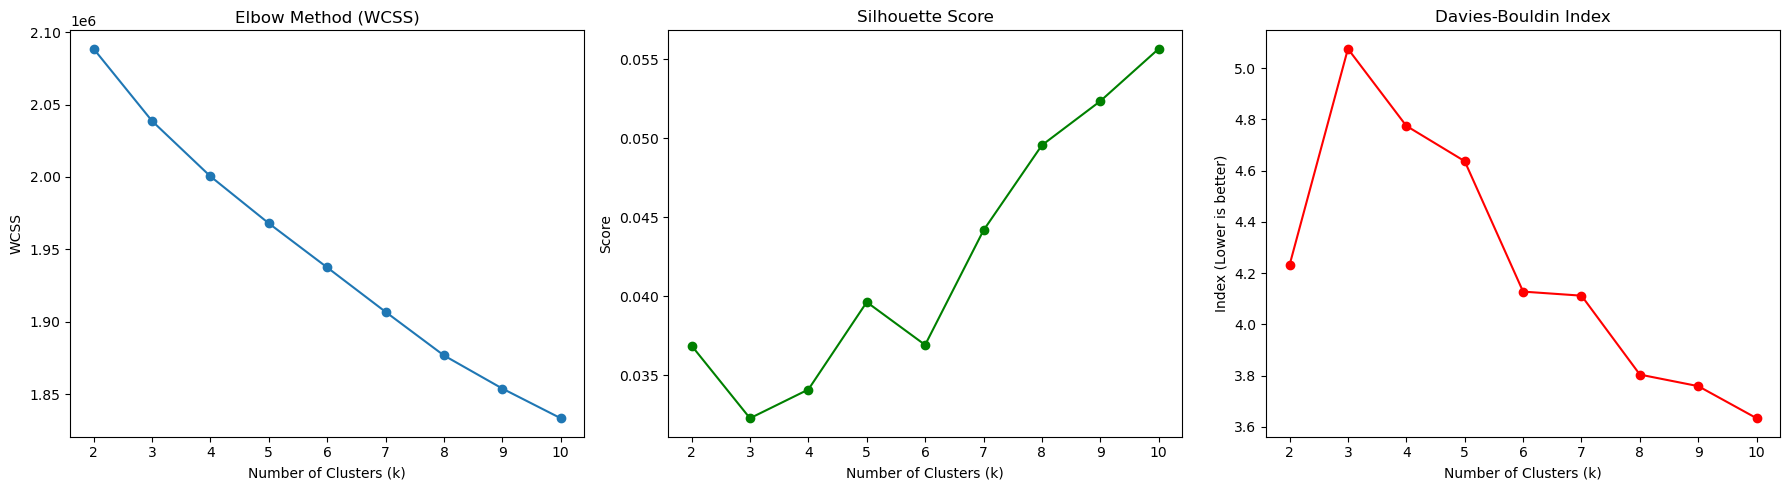


✅ Silhouette Score 기준 최적 k: 10
✅ Davies-Bouldin Index 기준 최적 k: 10


In [66]:
# title_embeddings + duration, title_length, word_count 포함된 통합 피처
result = find_optimal_k(X_combined, k_range=range(2, 11))

In [70]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
title_df['cluster'] = kmeans.fit_predict(X_combined)

for i in range(n_clusters):
    print(f"\n🔹 클러스터 {i} 예시 제목:")
    print(title_df[title_df['cluster'] == i]['title_x'].head(3).to_string(index=False))

C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



🔹 클러스터 0 예시 제목:
마라로제엽떡+닭꼬치 꿀조합•노티드 딸기전메뉴🍓먹고 결국 컵라면2개로 마무리•옛날통닭 ...
vlog | 집순이의 주말 삼시세끼 집밥 🛋️ 💭  두툼한 함박스테이크가 올라간 투움...
                                 한국 와서 오지게 먹는 브이로그

🔹 클러스터 1 예시 제목:
          아오니의 혼자 새 닌텐도 사러가는 브이로그★ (feat.세번째섬)
오징어게임2 3분 요약 [Squid Game II 3 Minutes Summary]
               왜 아이폰에서 제일 재밌는 게임이 닌텐도가 되어버렸을까?

🔹 클러스터 2 예시 제목:
       광기 다이어터의 72시간 밀착 브이로그 | 정신 차리고 다이어트 시작🏃‍♀️🚨
        [다이어트브이로그#2] 3일동안 계란이랑 단백질바만 먹으면 얼마나 빠질까?🥚
출산특집#6 먹어야 회복하지!! 자연분만 산모 회복 브이로그, 출산 직후 뭘 먹나? ...

🔹 클러스터 3 예시 제목:
                            오사카&교토 브이로그 • 쇼핑에미띤여자들
[VLOG] 일상 브이로그 | 3월 나의 생일을 맞이하며..🌷 | 이재모피자 제주점 ...
                           둘째 임신했습니다!!!🎉 (연년생 확정😭)

🔹 클러스터 4 예시 제목:
저 드디어 강남에 샵 오픈했어요😭취향 가득 담은 제 샵을 소개합니다🤍 | 인테리어 브...
                                  나 말고 송혜교 브이로그...
 vlog 딸빼고 엄마아빠 데이트👩‍❤‍👨리빙페어, 하이디라오 첫도전, 커트러리&잠옷 쇼핑

🔹 클러스터 5 예시 제목:
                  집도 없고 차도 없는 서민의 인생 첫 명품하울 브이로그
페라리의 나라에서 온 이탈리아 장인어른이 제네시스G90을 보고 두눈을 의심한 이유 ㅎㅎ
                               천만원짜리 카니발 풀옵션 만들

In [72]:
title_df

,title_x,video_id,published_date,thumbnail_url,view_count,like_count,comment_count,duration,channel_id,subscriber_count,...,emoji_count,has_emoji,special_char_count,is_clickbait,has_question_mark,has_exclamation,top_noun_1,top_noun_2,top_noun_3,cluster
0,결국 긴팔문신 제거 하는 조두팔,t-zwVkTOZA8,2025-03-28,https://i.ytimg.com/vi/t-zwVkTOZA8/maxresdefau...,244420.0,NaN,221.0,459.0,"('조두팔', '@조두팔이라고')",412000.0,...,0,0,0,0,False,False,문신,제거,NaN,7
1,[vlog] 고등학교 교사 직장인 브이로그 | 학부모 총회 그리고 상담 가득한 한 ...,AMwSEsFVRGg,2025-03-28,https://i.ytimg.com/vi/AMwSEsFVRGg/maxresdefau...,11267.0,265.0,54.0,1117.0,"('HappyHojin', '@Happppyhojin')",46500.0,...,3,1,9,0,False,False,고등학교,교사,직장인,7
2,오사카&교토 브이로그 • 쇼핑에미띤여자들,PocqBywf0FU,2025-02-24,https://i.ytimg.com/vi/PocqBywf0FU/maxresdefau...,12158.0,315.0,110.0,1306.0,"('권예왕왕', '@ye_one_e')",15700.0,...,0,0,1,0,False,False,오사카,교토,쇼핑,3
3,마라로제엽떡+닭꼬치 꿀조합•노티드 딸기전메뉴🍓먹고 결국 컵라면2개로 마무리•옛날통닭...,6eNhJ4LYr1k,2025-03-29,https://i.ytimg.com/vi/6eNhJ4LYr1k/maxresdefau...,14333.0,441.0,71.0,1772.0,"('째링', '@buttermellowday')",71700.0,...,1,1,4,0,False,False,엽떡,닭꼬치,조합,0
4,[썰레디윗미] 이젠 말할 수 있다🙄 역대급 똥차 썰 낋여오니라.ㅣ이게 실화라고? 구...,G9tXGudpOCo,2025-03-28,https://i.ytimg.com/vi/G9tXGudpOCo/maxresdefau...,58409.0,NaN,118.0,1097.0,"('냔지 nyanji', '@quya_a')",296000.0,...,3,1,5,1,True,False,레디,역대,똥차,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7303,(광고❌) 지금 바로 적용되는 저렴한 호텔 예약 꿀팁 🧑🏻‍💻 이건 몰랐을걸..절대...,GPWGgXXT1Aw,2025-01-31,https://i.ytimg.com/vi/GPWGgXXT1Aw/maxresdefau...,59924.0,1928.0,64.0,890.0,"('시월필름 October-film', '@시월필름')",45200.0,...,4,1,5,0,False,True,광고,지금,바로,3
7304,"12월에 또 갈 결심(온천호텔, 탄금호 캠핑장, 커피 주는 박물관, 한복 셀프사진관)",Q5uzsA3_oTE,2024-11-29,https://i.ytimg.com/vi/Q5uzsA3_oTE/maxresdefau...,348120.0,11536.0,1000.0,2072.0,"('[하말넘많] heavytalker', '@heavytalker')",682000.0,...,0,0,5,0,False,False,결심,온천,호텔,3
7305,일본 캡슐호텔에서 50시간 살아보기 | 일본#2,ZDUE_TI-od8,2024-07-01,https://i.ytimg.com/vi/ZDUE_TI-od8/maxresdefau...,857932.0,8408.0,676.0,584.0,"('서재로36', '@서재로36')",552000.0,...,0,0,2,0,False,False,일본,NaN,NaN,3
7306,세계에서 가장 작은 나라의 가장 작은 호텔,ubnBh-HRcrc,2023-12-25,https://i.ytimg.com/vi/ubnBh-HRcrc/maxresdefau...,2799502.0,25017.0,1200.0,1351.0,"('서재로36', '@서재로36')",552000.0,...,0,0,0,0,False,False,가장,세계,나라,3
